Los datos son una escuesta realizada a las amas de casa en el año 1978 con el fin de descubrir los factores que llevaban a buscar relaciones extratrimobiales. 

**El aprendizaje supervizado** no siempre consiste en predecir y en este caso nos limitaremos a **intentar a identificar los factores mas importantes** que podrian llevar a alguien a una una aventura.

In [30]:
# http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html
import statsmodels.api as sm
affairs_df = sm.datasets.fair.load_pandas().data
affairs_df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


The statsmodelswebsite provides a data dictionary, as follows:
*  rate_marriage: The rating given to the marriage (given by the wife), 1 = very poor, 2 = poor, 3 = fair, 4 = good, 5 = very good; ordinal level
*  age: Age of the wife; ratio level
*  yrs_married: Number of years married: ratio level
*  children: Number of children between husband and wife: ratio level
*  religious: How religious the wife is, 1 = not, 2 = mildly, 3 = fairly, 4 = strongly; ordinal level
*  educ: Level of education, 9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree; ratio level
*  occupation: 1 = student, 2 = farming, agriculture; semi-skilled, or unskilled worker; 3 = white-collar; 4 = teacher, counselor, social worker, nurse; artist, writers; technician, skilled worker, 5 = managerial, administrative, business, 6 = professional with advanced degree; nominal level because it cannot be ordered
*  occupation_husb: Husband's occupation. Same as occupation; nominal level because it cannot be ordered
*  affairs: Measure of time spent in extramarital affairs; ratio level

> esta ultima colunma nos no interesa mucho pq no tiene sentido saber el tiempo que dedica a las aventuras por eso convirtamoslo en una var. booleana

In [31]:
affairs_df.affairs = (affairs_df['affairs'] > 0)

# matriz de correlacion 
affairs_df.corr()['affairs'].sort_values()

rate_marriage     -0.331776
religious         -0.129299
educ              -0.075280
occupation_husb    0.017637
occupation         0.028981
age                0.146519
children           0.159833
yrs_married        0.203109
affairs            1.000000
Name: affairs, dtype: float64

occupation and occupation_husb son variables del nivel nominal (no se pueden ordenar) por lo que no tiene sentido su correlacion 

<AxesSubplot:>

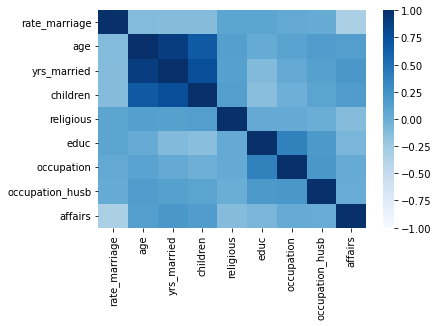

In [32]:
import seaborn as sns
import pandas as pd

# look at our correlation heat map (mapa de calor)
cmaps = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10',
         'tab20', 'tab20b', 'tab20c', 'flag', 'prism', 'ocean', 'gist_earth', 'terrain',
         'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow',
         'rainbow', 'jet', 'nipy_spectral', 'gist_ncar','Purples', 'Blues']

# sns.heatmap(affairs_df.corr(), cmap='Blues', annot=True)

sns.heatmap(affairs_df.corr(), vmin=-1, vmax=1, cmap=cmaps[-1])


In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
# data without the affairs or affair_binary column
affairs_X = affairs_df.drop(['affairs'], axis=1)
affairs_y = affairs_df['affairs']

# instantiate the model
model = DecisionTreeClassifier()
# import our cross validation module
# check the accuracy on the training set
scores = cross_val_score(model, affairs_X, affairs_y, cv=10)
print(scores.mean(), "average accuracy")
print(scores.std(), "standard deviation")  # very low, meaning variance of the model is low


0.6588102149422903 average accuracy
0.017844901381209085 standard deviation


Como nuestra standard deviation podemos asumir que la varianza del modelo es baja(vairianza es el cuadrado de la desviación estandar). Esto significa que nuestro modelo no se ajusta de manera muy diferente en cada pliegue(fold) de la  cross-validation y en general es un modelo fiable.

In [34]:
# Explore individual features that make the biggest impact
# rate_marriage, yrs_married, and occupation_husb. But occupation variable  don't quite make sense because they are nominal

model.fit(affairs_X, affairs_y)
pd.DataFrame({'feature': affairs_X.columns, 'importance': model.feature_importances_}
             ).sort_values('importance').tail(3)


,feature,importance
2,yrs_married,0.139170
0,rate_marriage,0.140949
7,occupation_husb,0.176124


La variable mas importante es *ocupation_husb* pero no tiene mucho sentido pq esa variable esta el nivel nominal(no se pueden ordenar sus valores). Por eso vamos a Apricarle la técnica de **Dummy Variables**

In [35]:
''' Dummy Variables:'''

# Encoding qualitiative (nominal) data using separate columns
occuptation_dummies = pd.get_dummies(affairs_df['occupation'],
                                     prefix='occ_')
# concatenate the dummy variable columns onto the original DataFrame 
affairs_df = pd.concat([affairs_df, occuptation_dummies], axis=1)

# Now for the husband's job
occuptation_dummies = pd.get_dummies(affairs_df['occupation_husb'], prefix='occ_husb_')

# concatenate the dummy variable columns onto the original DataFrame 
affairs_df = pd.concat([affairs_df, occuptation_dummies], axis=1)
affairs_df.head()


,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,occ__1.0,...,occ__3.0,occ__4.0,occ__5.0,occ__6.0,occ_husb__1.0,occ_husb__2.0,occ_husb__3.0,occ_husb__4.0,occ_husb__5.0,occ_husb__6.0
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,True,0,...,0,0,0,0,0,0,0,0,1,0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,True,0,...,1,0,0,0,0,0,0,1,0,0
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,True,0,...,1,0,0,0,0,0,0,0,1,0
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,True,0,...,0,0,1,0,0,0,0,0,1,0
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,True,0,...,1,0,0,0,0,0,0,1,0,0


In [36]:
# remove appropiate columns for feature set
affairs_X = affairs_df.drop(['affairs', 'occupation', 'occupation_husb'], axis=1)
affairs_y = affairs_df['affairs']

model = DecisionTreeClassifier()
# check the accuracy on the training set
scores = cross_val_score(model, affairs_X, affairs_y, cv=10)
print(scores.mean(), "average accuracy")
print(scores.std(), "standard deviation")

# Explore individual features that make the biggest impact
model.fit(affairs_X, affairs_y)
pd.DataFrame(
    {'feature': affairs_X.columns, 'importance': model.feature_importances_}).sort_values(
    'importance').tail(5)


0.6553560321080536 average accuracy
0.0173763805923831 standard deviation


,feature,importance
1,age,0.105864
3,children,0.125090
5,educ,0.126070
2,yrs_married,0.136277
0,rate_marriage,0.140589


Y aqui tenemos las 5 variables mas importantes para q una mujer le fuera infiel en el año 1978